In [ ]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

import os
import zipfile
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

url = "https://dyslexia.computing.clemson.edu/BET_BSE/BET_BSE_DATA.zip"
filename = os.path.join(os.getcwd(), "BET_BSE_DATA.zip")
keras.utils.get_file(filename, url)



5084553216/5084537526 [==============================] - 54s 0us/step


'/content/BET_BSE_DATA.zip'

In [ ]:
os.makedirs("MosMedData")
with zipfile.ZipFile("BET_BSE_DATA.zip", "r") as z_fp:
    z_fp.extractall("./MosMedData/")

In [ ]:
paths = [
    os.path.join(os.getcwd(), "MosMedData/BET_BSE_DATA/files", x)
    for x in os.listdir("MosMedData/BET_BSE_DATA/files")
]

In [ ]:
import nibabel as nib

from scipy import ndimage

def read_nifti_file(filepath):
    """Read and load volume"""
    # Read file
    scan = nib.load(filepath)
    # Get raw data
    scan = scan.get_fdata()
    return scan


def normalize(volume):
    """Normalize the volume"""
    min = -1000
    max = 400
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    return volume.astype("float32")

def resize_volume(img):
    """Resize across z-axis"""
    # Set the desired depth
    desired_depth = 64
    desired_width = 128
    desired_height = 128
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Rotate
    img = ndimage.rotate(img, 90, reshape=False)
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img


def process_scan(path):
    """Read and resize volume"""
    # Read scan
    volume = read_nifti_file(path)
    # Normalize
    volume = normalize(volume)
    # Resize width, height and depth
    # Read scan
    volume = resize_volume(volume)
    return volume

In [ ]:
import numpy as np
from google.colab import files
import pandas as pd
uploaded = files.upload()

ex = pd.read_csv('Label_file.csv')

ex["Recognizable-Facial-Feature"]=ex["Recognizable-Facial-Feature"].eq('Yes').mul(1)
ex["Brain-Feature-Loss"]=ex["Brain-Feature-Loss"].eq('Yes').mul(1)

Saving Label_file.csv to Label_file.csv


In [ ]:
count=0
y_train1=[]
y_train2=[]
scan=[]
for path in paths :
  if count <500 :
    scan.append(process_scan(path))
    y_train1.append(ex.iloc[count,1])
    y_train2.append(ex.iloc[count,2])
  count+=1


In [ ]:
count=0
y_train1_val=[]
y_train2_val=[]
val=[]
for path in paths :
  if count >500 and count <800 :
    val.append(process_scan(path))
    y_train1_val.append(ex.iloc[count,1])
    y_train2_val.append(ex.iloc[count,2])
  count+=1

In [ ]:
train_loader = tf.data.Dataset.from_tensor_slices((scan, y_train2))
validation_loader = tf.data.Dataset.from_tensor_slices((val, y_train2_val))

In [ ]:
def train_model(width=128, height=128, depth=64):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=256, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model


# Build model.
model = train_model(width=128, height=128, depth=64)
model.summary()

Model: "3dcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 64, 1)  0         
                             ]                                   
                                                                 
 conv3d (Conv3D)             (None, 126, 126, 62, 64)  1792      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 63, 63, 31, 64)   0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 63, 63, 31, 64)   256       
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 61, 61, 29, 64)    110656    
                                                             

In [ ]:
train_dataset = (
    train_loader.shuffle(len(scan))
    .batch(3)
    .prefetch(2)
)

validation_dataset = (
    validation_loader.shuffle(len(val))
    .batch(3)
    .prefetch(2)
)



In [ ]:
learning_rate = 0.0001
learning_rate_schedule = keras.optimizers.schedules.ExponentialDecay(
    learning_rate, decay_steps=100, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate_schedule),
    metrics=["acc"],
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_image_classification.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

# Train the model, doing validation at the end of each epoch
epochs = 3
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/3
167/167 - 6055s - loss: 0.6901 - acc: 0.5720 - val_loss: 0.7407 - val_acc: 0.5418 - 6055s/epoch - 36s/step
Epoch 2/3
167/167 - 6042s - loss: 0.6621 - acc: 0.6340 - val_loss: 1.0621 - val_acc: 0.5418 - 6042s/epoch - 36s/step
Epoch 3/3
167/167 - 6031s - loss: 0.6642 - acc: 0.6260 - val_loss: 0.8503 - val_acc: 0.5418 - 6031s/epoch - 36s/step


In [ ]:
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=10,
    shuffle=True,
    verbose=2
)

Epoch 1/10
73/73 - 253s - loss: 0.6918 - acc: 0.5479 - val_loss: 0.7310 - val_acc: 0.4035 - 253s/epoch - 3s/step
Epoch 2/10
73/73 - 248s - loss: 0.6836 - acc: 0.5571 - val_loss: 0.7364 - val_acc: 0.4211 - 248s/epoch - 3s/step
Epoch 3/10
73/73 - 248s - loss: 0.6908 - acc: 0.5251 - val_loss: 0.7398 - val_acc: 0.3333 - 248s/epoch - 3s/step
Epoch 4/10
73/73 - 248s - loss: 0.6873 - acc: 0.5388 - val_loss: 0.7350 - val_acc: 0.4386 - 248s/epoch - 3s/step
Epoch 5/10
73/73 - 245s - loss: 0.6891 - acc: 0.5799 - val_loss: 0.7270 - val_acc: 0.3860 - 245s/epoch - 3s/step
Epoch 6/10
73/73 - 243s - loss: 0.6818 - acc: 0.5388 - val_loss: 0.7396 - val_acc: 0.4035 - 243s/epoch - 3s/step
Epoch 7/10
73/73 - 244s - loss: 0.6983 - acc: 0.5023 - val_loss: 0.7356 - val_acc: 0.4035 - 244s/epoch - 3s/step
Epoch 8/10
73/73 - 242s - loss: 0.6929 - acc: 0.5023 - val_loss: 0.7239 - val_acc: 0.3684 - 242s/epoch - 3s/step
Epoch 9/10
73/73 - 245s - loss: 0.6895 - acc: 0.5251 - val_loss: 0.7428 - val_acc: 0.3860 - 245s

In [ ]:
count=0
y_test2=[]
scan_test=[]
for path in paths :
  if count > 800 :
    scan_test.append(process_scan(path))
    y_test2.append(ex.iloc[count,2])
  count+=1

In [ ]:
test_loader = tf.data.Dataset.from_tensor_slices((scan_test, y_test2))
test_dataset = (
    test_loader.shuffle(len(scan_test))
    .batch(3)
    .prefetch(2)
)


In [ ]:
TP=0
TN=0
FP=0
FN=0
for p in range(len(scan)) :
  prediction = model.predict(np.expand_dims(scan[p], axis=0))[0]
  if prediction[0] >= .5 and int(y_train1[p]) ==1 :
    TP+=1
  elif prediction[0] >= .5 and int(y_train1[p]) ==0 :
    FP+=1
  elif prediction[0] < .5 and int(y_train1[p]) ==0 :
    TN+=1
  elif prediction[0] < .5 and int(y_train1[p]) ==1 :
    FN+=1




In [ ]:
TP=0
TN=0
FP=0
FN=0
for p in range(len(scan)) :
  prediction = model.predict(np.expand_dims(scan[p], axis=0))[0]
  if prediction[0] <= .5 and int(y_train2[p]) ==1 :
    TP+=1
  elif prediction[0] > .5 and int(y_train2[p]) ==0 :
    TN+=1
  elif prediction[0] <= .5 and int(y_train2[p]) ==0 :
    FP+=1
  elif prediction[0] > .5 and int(y_train2[p]) ==1 :
    FN+=1

In [ ]:
prediction = model.predict(np.expand_dims(scan[398], axis=0))[0]
scores = [1 - prediction[0], prediction[0]]

class_names = ["normal", "abnormal"]
for score, name in zip(scores, class_names):
    print(
        "This model is %.2f percent confident that CT scan is %s"
        % ((100 * score), name)
    )

This model is 79.87 percent confident that CT scan is normal
This model is 20.13 percent confident that CT scan is abnormal


In [ ]:
print("TP : ",  TP , "TN : ", TN, "FP : ", FP , "FN : ",FN)

TP :  178 TN :  0 FP :  322 FN :  0


In [ ]:
accuracy = (TP + TN)/(TN + TP + FP + FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
F1 = (2*TP)/(2*TP + FP + FN)

print("accuracy :" , accuracy ,"precision : ", precision ,  "recall : ", recall , "F1 : ", F1)


accuracy : 0.356 precision :  0.356 recall :  1.0 F1 :  0.5250737463126843


In [ ]:
TP=0
TN=0
FP=0
FN=0
for p in range(len(scan)) :
  prediction = model.predict(np.expand_dims(scan[p], axis=0))[0]
  if prediction[0] >= .5 and int(y_train1[p]) ==1 :
    TP+=1
  elif prediction[0] >= .5 and int(y_train1[p]) ==0 :
    FP+=1
  elif prediction[0] < .5 and int(y_train1[p]) ==0 :
    TN+=1
  elif prediction[0] < .5 and int(y_train1[p]) ==1 :
    FN+=1

In [ ]:
accuracy = (TP + TN)/(TN + TP + FP + FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
F1 = (2*TP)/(2*TP + FP + FN)

print("accuracy :" , accuracy  ,"precision : ", precision ,  "recall : ", recall , "F1 : ", F1)

accuracy : 0.356 precision :  0.356 recall :  1.0 F1 :  0.5250737463126843


In [ ]:
result = model.evaluate(train_dataset)
dict(zip(model.metrics_names, result))

167/167 [==============================] - 671s 4s/step - loss: 0.7076 - acc: 0.6440


{'acc': 0.6439999938011169, 'loss': 0.7076351046562195}

In [ ]:
result = model.evaluate(test_dataset)
dict(zip(model.metrics_names, result))

KeyError: ignored

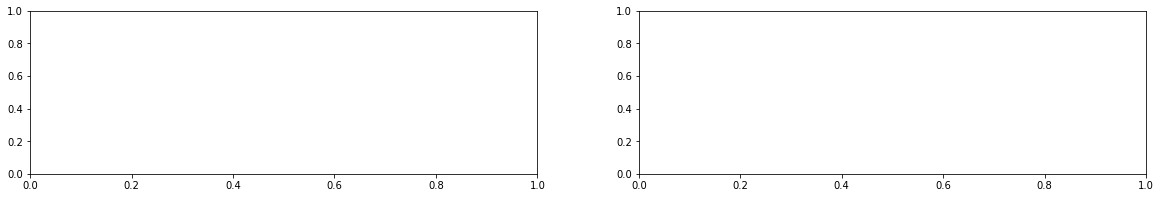

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])